---

# Clustering and Topic Modeling

The aim of this notebook is to provide analysis of tfidf, PCA decomp, clustering and topic modeling in the cleaned arXiv abstract data for papers with a subcategory in {[cs.AI](https://arxiv.org/list/cs.AI/recent), [cs.LG](https://arxiv.org/list/cs.LG/recent), [stat.ML](https://arxiv.org/list/stat.ML/recent)}.

---

## Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA, LatentDirichletAllocation
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.manifold import TSNE
import tqdm
import os

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Helper Functions

In [5]:
# return a fit TfIdf model with N number of maximum features
def vectorize(text, max_features):
    vectorizer = TfidfVectorizer(max_features = max_features)
    v = vectorizer.fit_transform(text)
    return v

## <i>Load the (collected & pre-processed) data</i>

In [6]:
fname = os.path.join(os.getcwd(), 'processed_data', 'preprocessed_data.csv')
dtypes = {}
for i in ['num_authors', 'num_categories', 'title_word_count']:
    dtypes[i] = np.uint8
for i in ['abstract_sentence_count', 'abstract_word_count', 'abstract_unique_word_count']:
    dtypes[i] = np.uint16
df = pd.read_csv(fname, parse_dates = ['created'], dtype = dtypes)
print(f"Dataframe shape:{df.shape}")

Dataframe shape:(103195, 22)


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
# for our purposes here, we will exclude the 2 examples that are in French and the 3 that have no abstract text.
df = df[(df.language == 'en')]
df = df[(~df.abstract_clean.isna())]
print(f"Cleaned dataframe shape:{df.shape}.")

Cleaned dataframe shape:(103190, 22).


In [8]:
df.columns

Index(['abstract', 'acm_class', 'arxiv_id', 'author_text', 'comments',
       'created', 'doi', 'num_authors', 'num_categories', 'primary_cat',
       'title', 'updated', 'category_cs_AI', 'category_cs_LG',
       'category_stat_ML', 'abstract_sentence_count', 'abstract_word_count',
       'abstract_unique_word_count', 'title_word_count', 'abstract_clean',
       'language', 'cluster'],
      dtype='object')

---

# Data Processing

- reduce to just (cs.AI, cs.LG, and stat.ML for PCA/KM/TSNE)
- Create Tf-Idf Model on $2^{12}$ (4,096) max features
- Use PCA to reduce Tf-Idf model to retain 95% components.
- Use KMeans and the [elbow method](https://blog.cambridgespark.com/how-to-determine-the-optimal-number-of-clusters-for-k-means-clustering-14f27070048f) for selecting optimal K.

---


In [6]:
# reduce to just cs.AI, cs.LG, and stat.ML (~65k)
df = df[(df.primary_cat.isin(['cs.AI','cs.LG','stat.ML']))]

# product tf-idf fit model with 4,096 maximum features over cleaned abstract
clean_text = vectorize(text = df.abstract_clean.values, max_features = 2 ** 12)
print(f"tfidf array shape:{clean_text.shape}.")

# utilize PCA dimensionality reduction, retaining 95% components
pca = PCA(n_components = 0.95, random_state = 42)
reduced = pca.fit_transform(clean_text.toarray())
print(f"PCA array shape:{reduced.shape}.")

tfidf array shape:(68318, 4096).
PCA array shape:(68318, 2933).


In [7]:
# evaluate K means with 2 to 50 K to find the optimal K using the elbow method.
euclidean, km_scores, silhouette, db = [], [], [], []

for k in range(2, 60):
    km = KMeans(n_clusters = k, random_state = 42).fit(reduced)
    preds = km.predict(reduced)

    # KMeans score
    out = -km.score(reduced)
    print(f"Score for number of clusters ({k}): {out}.")
    km_scores.append(out)
    
    # euclidean distortion
    out = sum(np.min(cdist(reduced, km.cluster_centers_, 'euclidean'), axis = 1)) / reduced.shape[0]
    print(f"Euclidean distortion for clusters ({k}): {out}")
    euclidean.append(out)

    # silhouette method
    out = metrics.silhouette_score(reduced, preds)
    print(f"Silhouette score for number of clusters ({k}): {out}")
    silhouette.append(out)
    
    out = metrics.davies_bouldin_score(reduced, preds)
    print(f"Davies Bouldin score for number of clusters ({k}): {out}.")
    db.append(out)
    
    print("-"*100)


Score for number of clusters (2): 62009.534030069124.
Euclidean distortion for clusters (2): 0.9523744756121992
Silhouette score for number of clusters (2): 0.005270108369181569
Davies Bouldin score for number of clusters (2): 8.081690921633072.
----------------------------------------------------------------------------------------------------
Score for number of clusters (3): 61677.846918016345.
Euclidean distortion for clusters (3): 0.9498043344687875
Silhouette score for number of clusters (3): 0.005881197054724824
Davies Bouldin score for number of clusters (3): 10.32199692655758.
----------------------------------------------------------------------------------------------------
Score for number of clusters (4): 61384.30044813836.
Euclidean distortion for clusters (4): 0.9474152010660659
Silhouette score for number of clusters (4): 0.006801015584182438
Davies Bouldin score for number of clusters (4): 8.85402251402807.
--------------------------------------------------------------

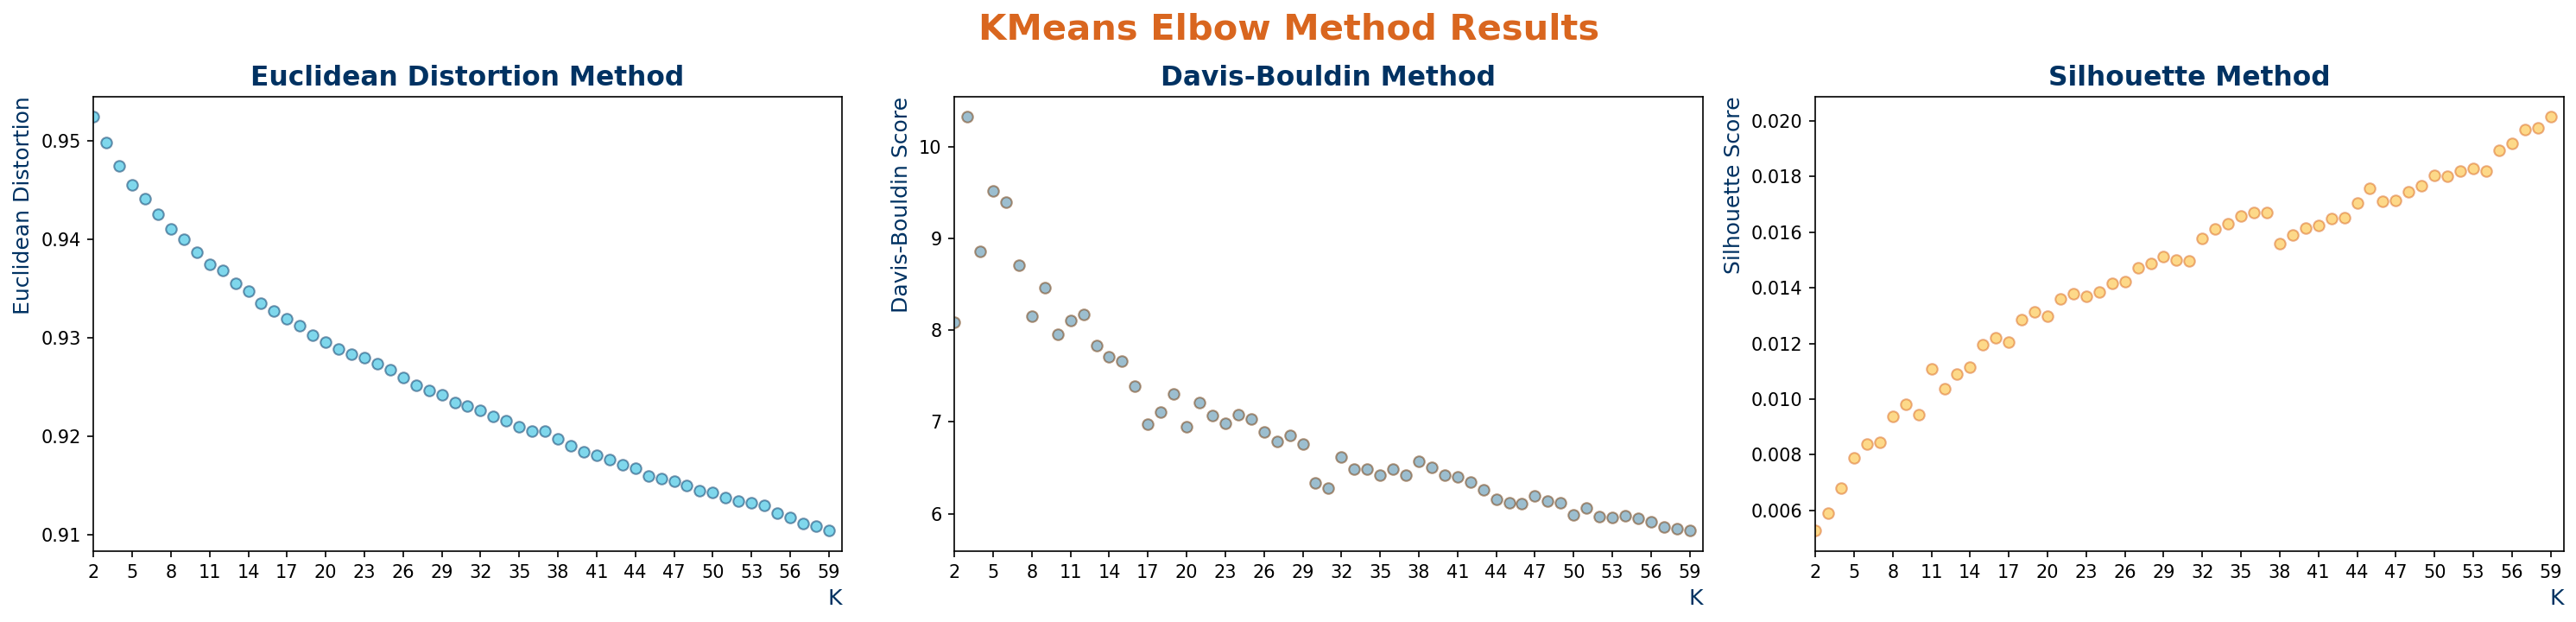

In [8]:
berkeley_palette = {'berkeley_blue'     : '#003262',
                    'california_gold'   : '#fdb515',
                    'founders_rock'     : '#3b7ea1',
                    'medalist'          : '#c4820e',
                    'bay_fog'           : '#ddd5c7',
                    'lawrence'          : '#00b0da',
                    'sather_gate'       : '#b9d3b6',
                    'pacific'           : '#46535e',
                    'soybean'           : '#859438',
                    'south_hall'        : '#6c3302',
                    'wellman_tile'      : '#D9661F',
                    'rose_garden'       : '#ee1f60',
                    'golden_gate'       : '#ed4e33',
                    'lap_lane'          : '#00a598',
                    'ion'               : '#cfdd45',
                    'stone_pine'        : '#584f29',
                    'grey'              : '#eeeeee',
                    'web_grey'          : '#888888',
                    # alum only colors
                    'metallic_gold'     : '#BC9B6A',
                    'california_purple' : '#5C3160'                   
                    }

fig = plt.figure(figsize = (20, 5), dpi = 150)
ax = fig.add_subplot(131)

xlen = len(euclidean) + 2

abs_data = pd.Series(euclidean)
ax.scatter(range(2, xlen), abs_data, color = berkeley_palette['lawrence'], alpha = 0.5, edgecolor = berkeley_palette['berkeley_blue'])
#ax.plot(range(2, xlen), abs_data, color = berkeley_palette['pacific'], linestyle = '--', alpha = 1, linewidth = 3)
ax.set_xlabel("K", fontsize = 12, horizontalalignment = 'right', x = 1.0, color = berkeley_palette['berkeley_blue'])
ax.set_ylabel("Euclidean Distortion", fontsize = 12, horizontalalignment = 'right', y = 1.0, color = berkeley_palette['berkeley_blue'])
ax.set_xlim(2, xlen)
ax.set_xticks(range(2, xlen, 3))
plt.title("Euclidean Distortion Method", fontsize = 15, fontweight = 'bold', color = berkeley_palette['berkeley_blue'])

ax = fig.add_subplot(132)
abs_data = pd.Series(db)
ax.scatter(range(2, xlen), abs_data, color = berkeley_palette['founders_rock'], alpha = 0.5, edgecolor = berkeley_palette['south_hall'])
#ax.plot(range(2, xlen), abs_data, color = berkeley_palette['pacific'], linestyle = '--', alpha = 1, linewidth = 3)
ax.set_xlabel("K", fontsize = 12, horizontalalignment = 'right', x = 1.0, color = berkeley_palette['berkeley_blue'])
ax.set_ylabel("Davis-Bouldin Score", fontsize = 12, horizontalalignment = 'right', y = 1.0, color = berkeley_palette['berkeley_blue'])
ax.set_xlim(2, xlen)
ax.set_xticks(range(2, xlen, 3))
plt.title("Davis-Bouldin Method", fontsize = 15, fontweight = 'bold', color = berkeley_palette['berkeley_blue'])

ax = fig.add_subplot(133)
auth_data = pd.Series(silhouette)
ax.scatter(range(2, xlen), auth_data, color = berkeley_palette['california_gold'], alpha = 0.5, edgecolor = berkeley_palette['wellman_tile'])
#ax.plot(range(2, xlen), auth_data, color = berkeley_palette['pacific'], linestyle = '--', alpha = 1, linewidth = 3)
ax.set_xlabel("K", fontsize = 12, horizontalalignment = 'right', x = 1.0, color = berkeley_palette['berkeley_blue'])
ax.set_ylabel("Silhouette Score", fontsize = 12, horizontalalignment = 'right', y = 1.0, color = berkeley_palette['berkeley_blue'])
ax.set_xlim(2, xlen)
ax.set_xticks(range(2, xlen, 3))
plt.title("Silhouette Method", fontsize = 15, fontweight = 'bold', color = berkeley_palette['berkeley_blue'])

plt.suptitle("KMeans Elbow Method Results", fontsize = 20, fontweight = 'bold', color = berkeley_palette['wellman_tile'])
plt.tight_layout(rect=[0, 0.03, 1, 0.93])
plt.show()

In [9]:
## We're going to go with K = 15; let's write the prediction
k = 15
km = KMeans(n_clusters = k, random_state = 42).fit(reduced)
df['cluster'] = km.predict(reduced)

In [11]:
# fit tSNE
tsne = TSNE(verbose = True, perplexity = 50, random_state = 42)
tsne_embedded = tsne.fit_transform(reduced)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 68318 samples in 61.426s...
[t-SNE] Computed neighbors for 68318 samples in 20215.105s...
[t-SNE] Computed conditional probabilities for sample 1000 / 68318
[t-SNE] Computed conditional probabilities for sample 2000 / 68318
[t-SNE] Computed conditional probabilities for sample 3000 / 68318
[t-SNE] Computed conditional probabilities for sample 4000 / 68318
[t-SNE] Computed conditional probabilities for sample 5000 / 68318
[t-SNE] Computed conditional probabilities for sample 6000 / 68318
[t-SNE] Computed conditional probabilities for sample 7000 / 68318
[t-SNE] Computed conditional probabilities for sample 8000 / 68318
[t-SNE] Computed conditional probabilities for sample 9000 / 68318
[t-SNE] Computed conditional probabilities for sample 10000 / 68318
[t-SNE] Computed conditional probabilities for sample 11000 / 68318
[t-SNE] Computed conditional probabilities for sample 12000 / 68318
[t-SNE] Computed conditional probabilities f

In [20]:
df['tsne_X'] = tsne_embedded.T[0].astype(np.float16)
df['tsne_Y'] = tsne_embedded.T[1].astype(np.float16)
# preserve file; that TSNE run took awhile...
df.to_csv('./processed_data/primary_categories_clustered.csv', index = False, sep = ',', mode = 'w')

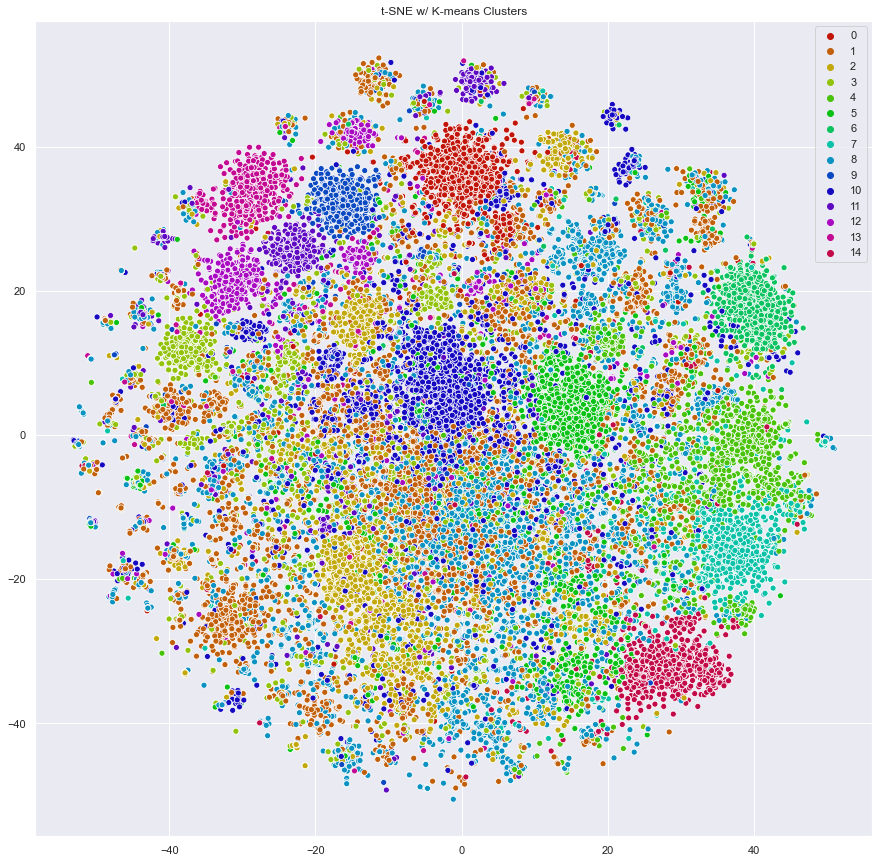

In [10]:
# rudimentary plot
sns.set(rc={'figure.figsize':(15,15)})
palette = sns.hls_palette(15, l = .4, s = .9)

sns.scatterplot(df.tsne_X.values, df.tsne_Y.values, hue = df.cluster.values, palette = palette, legend = 'full')
plt.title('t-SNE w/ K-means Clusters')
plt.show()

## LDA Topic Modeling

In [24]:
vectorizers, vectorized_data = [], []

# create a collection of Count Vectorizers for each K-means cluster
for i in range(0, k):
    vectorizers.append(CountVectorizer(min_df = 2, max_df = 0.9, token_pattern = '[a-zA-Z\-][a-zA-Z\-]{2,}'))

# for each vectorizer / cluster, generate the counts
for cluster, v in enumerate(vectorizers):
    try:
        vectorized_data.append(v.fit_transform(df.loc[df['cluster'] == cluster, 'abstract_clean']))
    except Exception as e:
        print("Not enough instances in cluster: " + str(cluster))
        vectorized_data.append(None)
print(f"{len(vectorized_data)} count vectorizers trained...")

15 count vectorizers trained...


In [30]:
# Est. number of topics per cluster
NUM_TOPICS_PER_CLUSTER = 10

lda_models, clusters_lda_data = [], []
for i in range(0, len(vectorizers)):
    # Latent Dirichlet Allocation Model
    lda = LatentDirichletAllocation(n_components = NUM_TOPICS_PER_CLUSTER, max_iter = 10, learning_method = 'online',verbose = False, random_state = 42)
    lda_models.append(lda)
    
for cluster, lda in enumerate(lda_models):
    if vectorized_data[cluster] != None:
        clusters_lda_data.append((lda.fit_transform(vectorized_data[cluster])))

In [36]:
# Functions for printing keywords for each topic
def selected_topics(model, vectorizer, top_n=3):
    current_words = []
    keywords = []
    
    for idx, topic in enumerate(model.components_):
        words = [(vectorizer.get_feature_names()[i], topic[i]) for i in topic.argsort()[:-top_n - 1:-1]]
        for word in words:
            if word[0] not in current_words:
                keywords.append(word)
                current_words.append(word[0])
                
    keywords.sort(key = lambda x: x[1])  
    keywords.reverse()
    return_values = []
    for ii in keywords:
        return_values.append(ii[0])
    return return_values

all_keywords = []
for current_vectorizer, lda in enumerate(lda_models):
    # print("Current Cluster: " + str(current_vectorizer))

    if vectorized_data[current_vectorizer] != None:
        all_keywords.append(selected_topics(lda, vectorizers[current_vectorizer]))


In [38]:
# save the topics file for each cluster
f = open('./processed_data/topics.txt','w')

for count, i in enumerate(all_keywords):
    if vectorized_data[count] != None:
        f.write(', '.join(i) + "\n")
    else:
        f.write("Not enough instances to be determined. \n")
        f.write(', '.join(i) + "\n")
f.close()
print("./processed_data/topics.txt written to disk.")

./processed_data/topics.txt written to disk.


# Generate the Bokeh Clusters Plot

In [1]:
#sneaker start (if resuming from dead session)
import os
import pandas as pd
import numpy as np

fname = os.path.join(os.getcwd(), 'processed_data', 'primary_categories_clustered.csv')
dtypes = {}
for i in ['num_authors', 'num_categories', 'title_word_count']:
    dtypes[i] = np.uint8
for i in ['abstract_sentence_count', 'abstract_word_count', 'abstract_unique_word_count']:
    dtypes[i] = np.uint16
df = pd.read_csv(fname, parse_dates = ['created'], dtype = dtypes)

df = df.groupby(by=['abstract', 'tsne_X', 'tsne_Y', 'cluster', 'title', 'author_text', 'primary_cat']).agg({'arxiv_id':'first'}).reset_index()
df = df.drop_duplicates(keep = 'first')

print(f"Dataframe shape:{df.shape}")

with open('./processed_data/topics.txt') as f:
    topics = f.readlines()
print(f"Length of topics: {len(topics)}")

Dataframe shape:(42131, 8)
Length of topics: 15


In [2]:
# generate the plot and save it to file (too large to load here)
from utils.plot_utils import selected_code, input_callback, bokeh_load_clusters_plot

output_filename = './reports/bokeh/t-sne_arxiv_abstracts.html'
bokeh_load_clusters_plot(df = df, topics = topics, output_filename = output_filename)
print(f"Bokeh plot saved to '{output_filename}'.")

Loading BokehJS ...

Bokeh plot saved to './reports/bokeh/t-sne_arxiv_abstracts.html'.
